In [1]:
%matplotlib

Using matplotlib backend: <object object at 0x10d7e6310>


In [2]:
import mne
from pprint import pprint
import json
import csv
import numpy as np
import pandas as pd
from pathlib import Path
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

In [5]:
root_data_path = Path("/Volumes/Neurolang_1/Project_Assistant/2021_Ongoing/2020_LTTC/Experiment_materials/LTTC_MEG")
meg_data_path = root_data_path / "LTTC_MEG_ALL_results"

print(root_data_path)

sub_id = 12

LDT_confile = meg_data_path / Path('de%.3d-2.con' %sub_id) 
LDT_raw =  mne.io.read_raw_kit(LDT_confile, stim = [195], preload=True) #, slope = '+') #slope=將3個stim_channel的訊號全部加成,讓訊號增強
                                                                #把原始的KIT資料讀進來
#LDT_raw.plot()
#events = mne.find_events(LDT_raw, stim_channel='STI 014') #將集合而成的channel命名為STI 014

#LDT_raw.plot()
n_LDT_raw = LDT_raw.copy()

n_LDT_raw.load_data().pick_types(meg=True, stim=True).filter(0, 30, phase='zero-double').resample(500)
print(n_LDT_raw.info)
#print(events.shape)

n_LDT_raw.plot()

/Volumes/Neurolang_1/Project_Assistant/2021_Ongoing/2020_LTTC/Experiment_materials/LTTC_MEG
Extracting SQD Parameters from /Volumes/Neurolang_1/Project_Assistant/2021_Ongoing/2020_LTTC/Experiment_materials/LTTC_MEG/LTTC_MEG_ALL_results/de012-2.con...
Creating Raw.info structure...
Setting channel info structure...
Creating Info structure...
Reading 0 ... 299999  =      0.000 ...   299.999 secs...
Ready.
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 33.75 Hz)
- Filter length: 441 samples (0.441 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
120 events found
Event IDs: [1]


[Parallel(n_jobs=1)]: Done 157 out of 157 | elapsed:    1.3s finished


Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
120 events found
Event IDs: [1]
<Info | 9 non-empty values
 bads: []
 ch_names: MEG 001, MEG 002, MEG 003, MEG 004, MEG 005, MEG 006, MEG 007, ...
 chs: 157 Magnetometers, 1 Stimulus
 custom_ref_applied: False
 description: Academia Sinica/Institute of Linguistics//Magnetoencephalograph ...
 highpass: 0.0 Hz
 kit_system_id: 261 (Academia Sinica, 2008-)
 lowpass: 30.0 Hz
 meas_date: 2022-12-07 19:06:11 UTC
 nchan: 158
 projs: []
 sfreq: 500.0 Hz
>
Using pyopengl with version 3.1.6


Waiting for Loading-Thread to finish... (max. 10 sec)
Channels marked as bad:
none


In [7]:
# ICA
ica_ = ICA(n_components=15, random_state=97)
ica_.fit(n_LDT_raw)
#ica_

#Plot ICA
ica_.plot_sources(n_LDT_raw)
ica_.plot_components()#sphere = (0.0, 0.02, 0.0, 0.065))  # What is this sphere for??
#ica_.plot_overlay(n_LDT_raw, exclude=[0, 5])  # 5 3 2 1

Fitting ICA to data using 157 channels (please be patient, this may take a while)


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_4917/4238994491.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica_.fit(n_LDT_raw)


Selecting by number: 15 components
Fitting ICA took 5.9s.
Creating RawArray with float64 data, n_channels=15, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.
Using pyopengl with version 3.1.6


[<MNEFigure size 1950x1463 with 15 Axes>]

In [8]:
# Checking for every component
for i in range(15):
    #ica_.plot_properties(n_raw, picks=[i])
    ica_.plot_overlay(n_LDT_raw, exclude=[i])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing o

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 157 PCA components


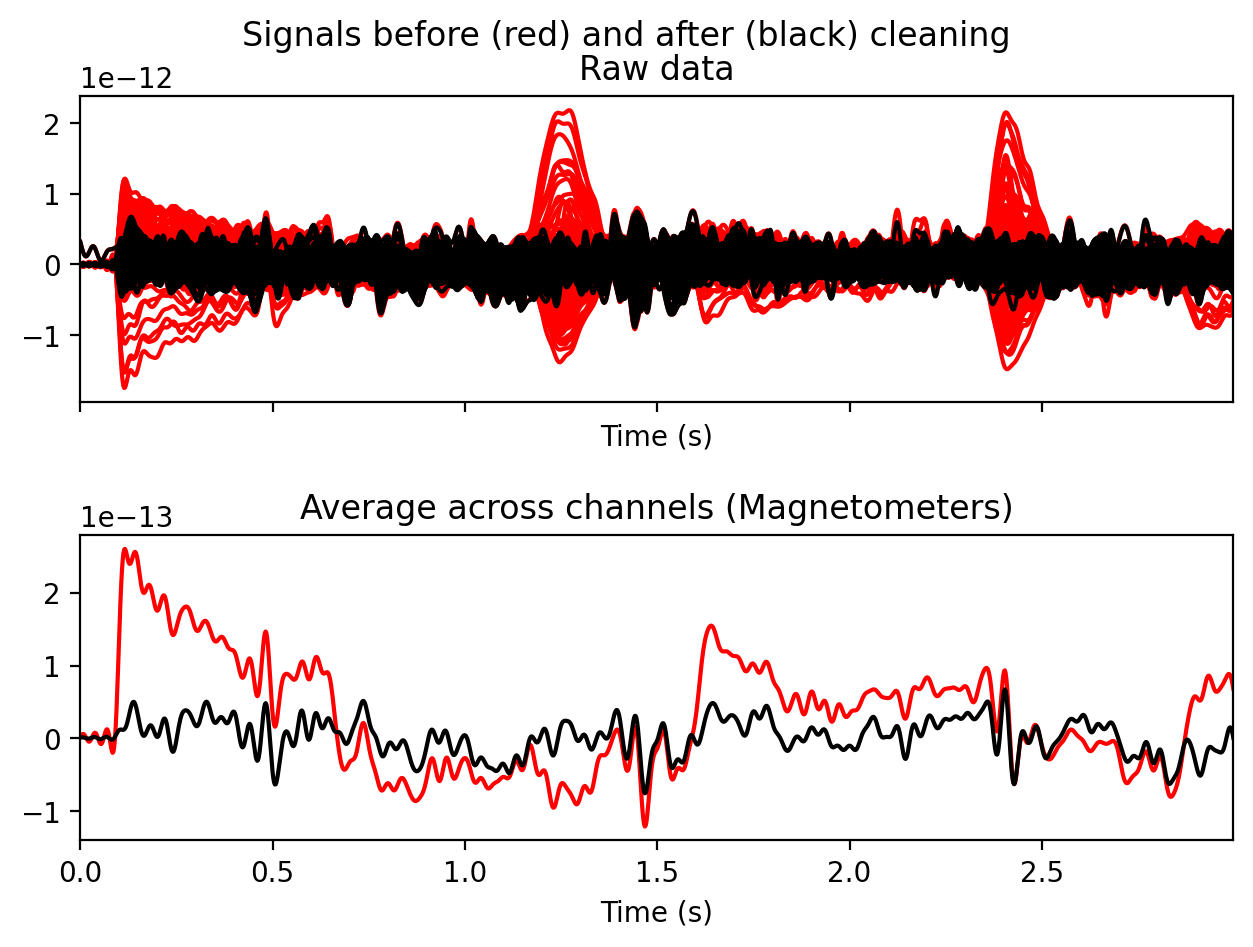

In [9]:
ica_.plot_overlay(n_LDT_raw, exclude=[0,1])

In [10]:
# ICAed epochs
# excluding wanted components
ica_.exclude = [0,1]
ica_.plot_overlay(n_LDT_raw, exclude=[i])

ica_.apply(n_LDT_raw) #changes the Raw object in-place, so let's make a copy first:
#n_LDT_raw.plot()

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 157 PCA components


<RawKIT | de012-2.con, 158 x 150000 (300.0 s), ~181.0 MB, data loaded>

In [11]:
# Creating the epochs(The Original one_without the tag of H&L-CD )
events = mne.find_events(n_LDT_raw, stim_channel='STI 014')  #just checking what stim_channel documenting what.
event_id = {'word_onset': 1}  

tmin = -0.1         								# pre stimulis interval (in seconds) #
tmax = 1       								# post stimulus interval #

baseline = (-0.1, 0)  # tmin ~ 0 , -0.1s-0s   
reject = dict(mag=4e-12)  # 5e-12 dropped so many

# Load in the channels layouts
kit_lay = mne.channels.read_layout("KIT-157")

#n_LDT_raw.load_data().pick_types(meg=True, stim=True).filter(0, 30, phase='zero-double').resample(500)
epoch_LDT = mne.Epochs(n_LDT_raw, events, event_id, tmin, tmax, baseline=baseline
                    , reject=reject,preload=True)

#epoch_LDT.plot()

Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
120 events found
Event IDs: [1]
Not setting metadata
120 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 120 events and 551 original time points ...
    Rejecting  epoch based on MAG : ['MEG 025', 'MEG 077', 'MEG 079', 'MEG 082', 'MEG 086', 'MEG 089', 'MEG 090', 'MEG 092', 'MEG 093', 'MEG 141', 'MEG 152', 'MEG 156']
1 bad epochs dropped


In [12]:
# get to know the reason of bad epoch drop
print(epoch_LDT.drop_log)

((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('MEG 025', 'MEG 077', 'MEG 079', 'MEG 082', 'MEG 086', 'MEG 089', 'MEG 090', 'MEG 092', 'MEG 093', 'MEG 141', 'MEG 152', 'MEG 156'), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ())


In [14]:
# Load in the csv file of word onset
print(root_data_path)
csv_data = root_data_path / "001-015_PLDT_raw_results.csv"  # self-made LMM data form

sub_ansLIST = []
with open(csv_data, "r", encoding="UTF-8") as f:
    fileLIST = f.read().split("\n")
    fileLIST.pop(0)  # exclude the headlines
    fileLIST.pop(-1) # exclude the last one (blank)
    
    #pprint(fileLIST[0:10][2])
    pprint(fileLIST)
    print(len(fileLIST))

/Volumes/Neurolang_1/Project_Assistant/2021_Ongoing/2020_LTTC/Experiment_materials/LTTC_MEG
['1,C,1,chaeviy,1,1,1339,',
 '1,L,2,laelaxst,1,0,1192,',
 '1,L,3,baepay,1,0,913,',
 '1,H,4,payliy,1,0,786,',
 '1,C,5,laeviy,1,1,979,',
 '1,H,6,vaesow,1,1,1257,',
 '1,H,7,browmey,1,0,1095,',
 '1,C,8,weyaet,1,1,1286,',
 '1,L,9,paenliy,1,1,952,',
 '1,C,10,maeskiy,1,1,1177,',
 '1,C,11,baydiy,1,1,1136,',
 '1,C,12,aegliy,1,0,1486,',
 '1,L,13,laelaxst,2,0,1170,',
 '1,C,14,maeskiy,2,1,967,',
 '1,C,15,laeviy,2,1,1046,',
 '1,H,16,vaesow,2,1,1146,',
 '1,H,17,payliy,2,0,1242,',
 '1,C,18,chaeviy,2,1,1125,',
 '1,C,19,baydiy,2,1,1217,',
 '1,C,20,weyaet,2,1,1575,',
 '1,L,21,baepay,2,0,1414,',
 '1,L,22,paenliy,2,1,1172,',
 '1,H,23,browmey,2,0,1483,',
 '1,C,24,aegliy,2,1,1541,',
 '1,H,25,vaesow,3,1,836,',
 '1,C,26,chaeviy,3,1,1061,',
 '1,H,27,browmey,3,0,1483,',
 '1,L,28,baepay,3,0,1223,',
 '1,C,29,maeskiy,3,1,1389,',
 '1,C,30,aegliy,3,1,1358,',
 '1,C,31,laeviy,3,1,1145,',
 '1,L,32,paenliy,3,1,1106,',
 '1,C,33,ba

In [16]:
# set up the sub_id into string
tmp_id = "%d" %sub_id
print(tmp_id)
print(type(tmp_id))

# create blank LIST for later use
sub_ansLIST = []

# create the LIST of the target sub's answer
for row in fileLIST:
    row = row.split(",")
    sub_id_STR = row[0]
    #print(sub_id_STR)
    #print(type(sub_id_STR))
    
    # check the sub_id in the whole dataset
    if sub_id_STR == tmp_id:
        sub_ansLIST.append(row)
    else:
        pass
        
pprint(sub_ansLIST)
print(len(sub_ansLIST))

12
<class 'str'>
[['12', 'C', '1', 'baepay', '1', '1', '2063', ''],
 ['12', 'C', '2', 'vaesow', '1', '0', '910', ''],
 ['12', 'C', '3', 'payliy', '1', '0', '608', ''],
 ['12', 'C', '4', 'aegliy', '1', '0', '2060', ''],
 ['12', 'L', '5', 'chaeviy', '1', '1', '1235', ''],
 ['12', 'C', '6', 'browmey', '1', '1', '732', ''],
 ['12', 'C', '7', 'laeviy', '1', '1', '730', ''],
 ['12', 'L', '8', 'weyaet', '1', '0', '1613', ''],
 ['12', 'L', '9', 'paenliy', '1', '1', '876', ''],
 ['12', 'H', '10', 'baydiy', '1', '1', '805', ''],
 ['12', 'H', '11', 'laelaxst', '1', '0', '1000', ''],
 ['12', 'H', '12', 'maeskiy', '1', '1', '1075', ''],
 ['12', 'C', '13', 'vaesow', '2', '0', '916', ''],
 ['12', 'H', '14', 'laelaxst', '2', '1', '1076', ''],
 ['12', 'L', '15', 'chaeviy', '2', '0', '1453', ''],
 ['12', 'L', '16', 'weyaet', '2', '1', '1284', ''],
 ['12', 'C', '17', 'aegliy', '2', '0', '1336', ''],
 ['12', 'H', '18', 'maeskiy', '2', '1', '1190', ''],
 ['12', 'L', '19', 'paenliy', '2', '1', '1062', ''],


In [17]:
all_eventsArray = events.copy()
#print(all_eventsArray[0][0])

# C == control group; H == H_CD; L == L_CD
# event_id >> C==9; H==1; L==2

C_LIST = []
H_LIST = []
L_LIST = []

# Change the event id according to the condition
for row in sub_ansLIST:
    #print(row)
    
    index_eventINT = sub_ansLIST.index(row)
    #print(index_eventINT)
    conditionSTR = row[1]
    #print(row[0], row[1])
    
    if conditionSTR == "C":
        #print(index_eventINT, "=", conditionSTR)
        all_eventsArray[index_eventINT][2] = 9
        #C_LIST.append(conditionSTR)

    if conditionSTR == "H":
        #print(index_eventINT, "=", conditionSTR)
        all_eventsArray[index_eventINT][2] = 1
        #H_LIST.append(conditionSTR)
        
    if conditionSTR == "L":       
        #print(index_eventINT, "=", conditionSTR)
        all_eventsArray[index_eventINT][2] = 2
        #L_LIST.append(conditionSTR)
    else:
        pass 

all_eventsArray

array([[ 18361,      0,      9],
       [ 19698,      0,      9],
       [ 20663,      0,      9],
       [ 21473,      0,      9],
       [ 23002,      0,      2],
       [ 24110,      0,      9],
       [ 24995,      0,      9],
       [ 25849,      0,      2],
       [ 27179,      0,      2],
       [ 28102,      0,      1],
       [ 29008,      0,      1],
       [ 30029,      0,      1],
       [ 31051,      0,      9],
       [ 32010,      0,      1],
       [ 33050,      0,      2],
       [ 34283,      0,      2],
       [ 35429,      0,      9],
       [ 36602,      0,      1],
       [ 37701,      0,      2],
       [ 38734,      0,      1],
       [ 39641,      0,      9],
       [ 41147,      0,      9],
       [ 42006,      0,      9],
       [ 42826,      0,      9],
       [ 43732,      0,      1],
       [ 44712,      0,      9],
       [ 45792,      0,      9],
       [ 47071,      0,      2],
       [ 48691,      0,      9],
       [ 49717,      0,      9],
       [ 5

In [18]:
# Creating the new epochs
events = all_eventsArray  #mne.find_events(raw_ICAed, stim_channel='STI 014')  #just checking what stim_channel documenting what.
event_id = {'High_CD':1,'Low_CD':2, 'Control': 9}  

tmin = -0.1         								# pre stimulis interval (in seconds) #
tmax = 0.7          								# post stimulus interval #

baseline = (None, 0)  # tmin ~ 0 , -0.1s-0s   
reject = dict(mag=4e-12)

# Load in the channels layouts
kit_lay = mne.channels.read_layout("KIT-157")

n_LDT_raw.load_data().pick_types(meg=True, stim=False).filter(0, 30, phase= 'zero-double').resample(500)
n_epoch_LDT = mne.Epochs(n_LDT_raw, events, event_id, tmin, tmax,
                    baseline=baseline,
                    reject = reject, preload = True)

n_epoch_LDT

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 33.75 Hz)
- Filter length: 221 samples (0.442 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 157 out of 157 | elapsed:    0.8s finished


Not setting metadata
120 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 120 events and 401 original time points ...
    Rejecting  epoch based on MAG : ['MEG 082', 'MEG 086', 'MEG 089', 'MEG 090', 'MEG 092', 'MEG 141', 'MEG 152', 'MEG 156']
1 bad epochs dropped


Number of events,119
Events,Control: 60High_CD: 29Low_CD: 30
Time range,-0.100 – 0.700 sec
Baseline,-0.100 – 0.000 sec


In [14]:
n_epoch_LDT.save(meg_data_path / Path('S%.3d_ICAed_LDT-epo.fif' %sub_id), overwrite=True)

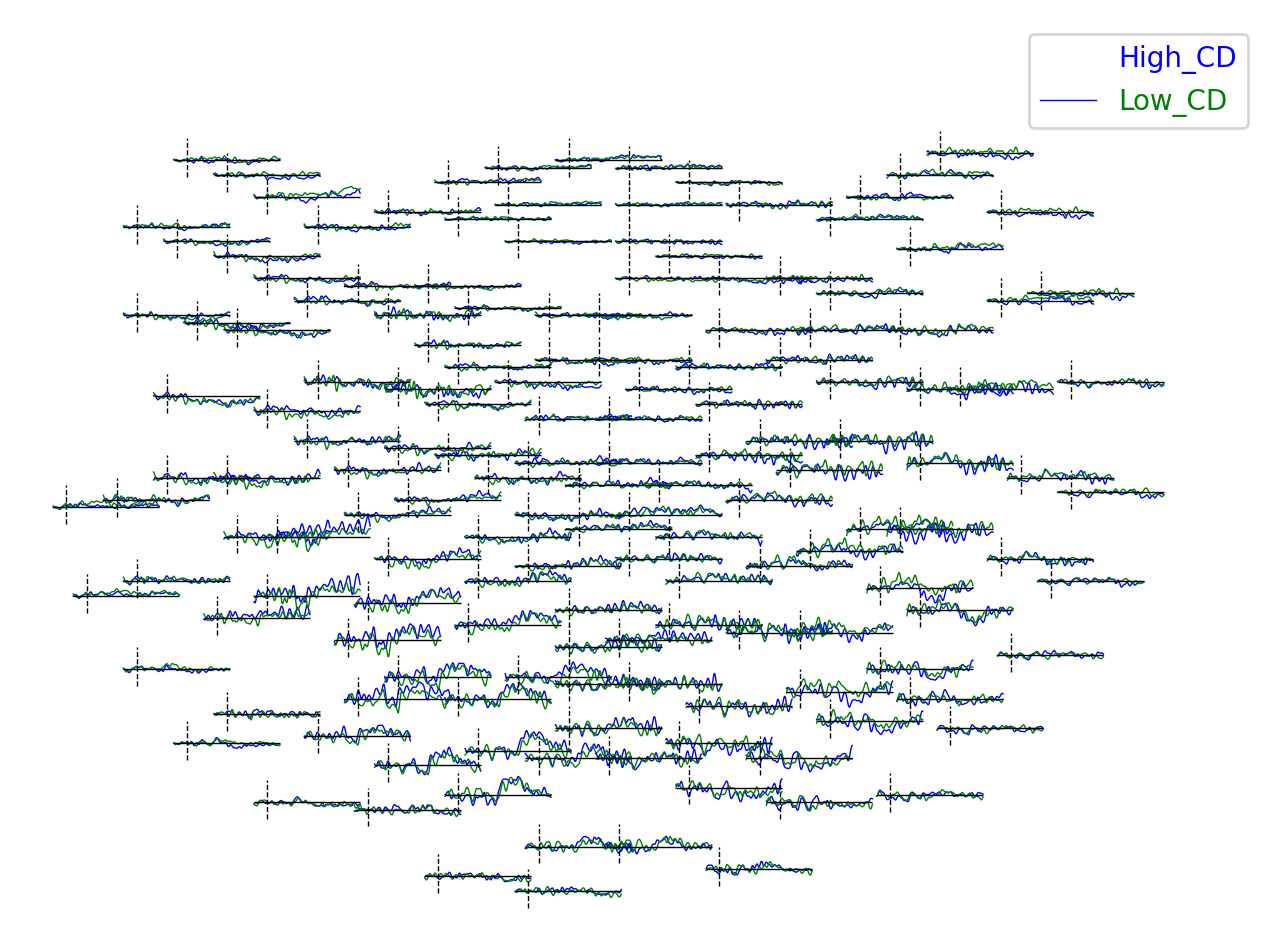

In [26]:
#evoked_C = n_epoch_LDT["Control"].average()
evoked_H = n_epoch_LDT["High_CD"].average()
evoked_L = n_epoch_LDT["Low_CD"].average()

#evoked_C.comment = 'Control'
evoked_H.comment = 'High_CD'
evoked_L.comment = 'Low_CD'

tmp = [evoked_H, evoked_L]#[evoked_C, evoked_H, evoked_L] 
colors = 'blue', 'green' #H:'blue'; L:'green'; C:'red'
mne.viz.plot_evoked_topo(tmp, color = colors)

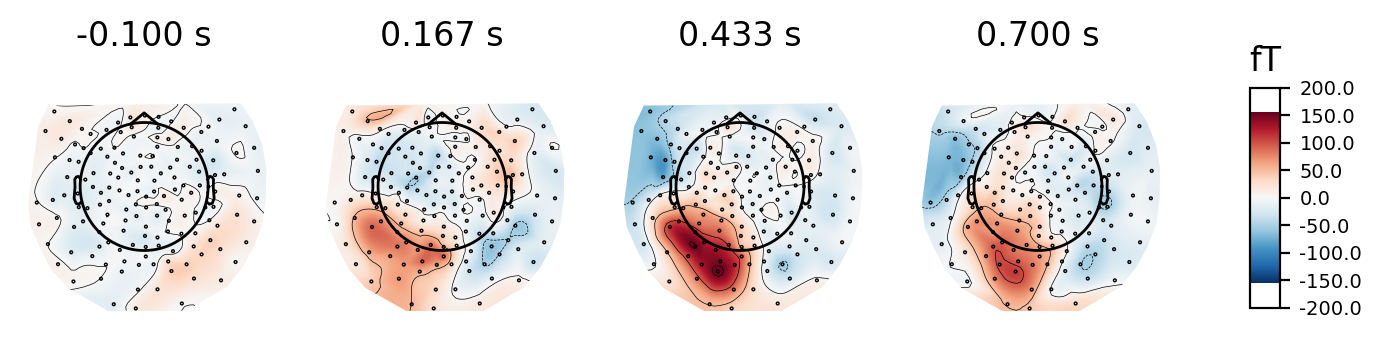

In [78]:
evoked_L.plot_topomap()

In [ ]:
# see the average of the epochs, I think

std_evoked = epochs['Standard (yi3)'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.7)
devL_evoked = epochs['Large deviant (yi1)'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.7)
devS_evoked = epochs['Small deviant (yi2)'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.7)

print(std_evoked)
print(devL_evoked)
print(devS_evoked)

In [ ]:
tmp = [std_evoked, devL_evoked, devS_evoked]
colors = 'red', 'blue', 'green'
#mne.viz.plot_evoked_topo(tmp, color = colors, title = 'MMN', ylim = dict(eeg=[10, -10]))
mne.viz.plot_compare_evokeds(tmp, colors = colors, axes = 'topo')